In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, accuracy_score, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import time
import pprint
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sksurv.preprocessing import OneHotEncoder


In [2]:
#load data
pd.set_option('display.max_columns', None)
df = pd.read_csv('imputed_revent.csv')
df = df.drop(axis=1, columns=['Unnamed: 0','last_careunit'])

In [3]:
'''df[df==np.inf]=np.nan
df.fillna(df.mean(), inplace=True)'''

'df[df==np.inf]=np.nan\ndf.fillna(df.mean(), inplace=True)'

## 1: Post-pre-processing

#### 1.1: Variable grouping

In [19]:
# variables for analysis
categorical = ['ethnicity', 
              'marital_status',
              'language',
              'admission_location',
              'gender',
              'insurance',
              'first_careunit',
              'admission_type']
proceduretype=['aortic','mit','tricuspid','pulmonary','cabg']
ptParams = ['weight', 'height', 'bmi']
boolFields = ['reintubation', 'liver_severe', 'liver_mild', 'rheum', 'cvd', 'aids', 'ckd', 'copd', 'arrhythmia', 'pud', 'smoking', 'pvd', 'paraplegia', 
              'ccf', 'met_ca', 't2dm', 't1dm', 'malig', 'mi', 'dementia', 'hospital_expire_flag', 'diab_un', 'diab_cc']
ptinfo = ['hadm_id', 'subject_id']
ptTimes = ['int_time1','ext_time1','int_time2','ext_time2','admittime', 'dischtime', 'deathtime','intime', 'outtime', 'ext_time', 'icustay_seq']
tsColumns_first = [i for i in df.columns if '_first' in i]
tsColumns_others = [i for i in df.columns if '_max' in i or '_min' in i or '_mean' in i]

inputs = [*categorical , *proceduretype , *tsColumns_first , *ptParams , *[i for i in boolFields if i != 'reintubation']]
inputs_all = [*categorical , *proceduretype , *tsColumns_first , *tsColumns_others, *ptParams , *[i for i in boolFields if i != 'reintubation'], 'duration1']
outcomes = ['reintubation','hospital_expire_flag','los','duration1','duration2','icu_stay_duration']

print([i for i in df.columns if i not in categorical + proceduretype + tsColumns_first + tsColumns_others + ptParams + boolFields + ptinfo + ptTimes + outcomes])
print([i for i in df.columns if i not in inputs + outcomes + ptTimes + tsColumns_others])


['temp_last', 'bg_temp_last', 'hr_last', 'spo2_last', 'rr_last', 'sbp_last', 'dbp_last', 'meanbp_last', 'cardiac_index_last', 'pt_last', 'ptt_last', 'inr_last', 'inr_1_last', 'fibrinogen_last', 'hb_last', 'hematocrit_last', 'wcc_last', 'lymphocytes_last', 'neutrophils_last', 'alp_last', 'ast_last', 'alt_last', 'bilirubin_total_last', 'chloride_last', 'magnesium_last', 'potassium_last', 'creatinine_last', 'free_calcium_last', 'sodium_last', 'bicarb_last', 'bun_last', 'hba1c_last', 'glucose_last', 'lactate_last', 'po2_last', 'pco2_last', 'baseexcess_last', 'ph_last', 'aado2_last', 'fio2_last', 'insulin_last', 'prbc_last', 'tidalvol_last', 'plt_last', 'infection_vent', 'censor']
['temp_last', 'bg_temp_last', 'hr_last', 'spo2_last', 'rr_last', 'sbp_last', 'dbp_last', 'meanbp_last', 'cardiac_index_last', 'pt_last', 'ptt_last', 'inr_last', 'inr_1_last', 'fibrinogen_last', 'hb_last', 'hematocrit_last', 'wcc_last', 'lymphocytes_last', 'neutrophils_last', 'alp_last', 'ast_last', 'alt_last', 'bi

In [20]:
# change categorical to category type
for col in categorical:
    df[col] = df[col].astype('category')

In [21]:
# create censor column for death before extubation
censor = []
for i in range(len(df)):
    if df['deathtime'][i] is np.NaN or df['deathtime'][i] >= df['ext_time1'][i]:
        censor.append(True)
    else:
        censor.append(False)
censored = []
for i in range(len(censor)):
    if censor[i] == False:
        censored.append(i)
print('Number censored: '+str(len(censored)))
print(censored)

df['censor'] = censor

Number censored: 4
[2500, 2962, 3106, 8193]


#### 1.2: !!X, Xt, y!!

In [22]:
# get X, Xt and y
X = df[inputs]
X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

y = df['reintubation']

In [17]:
# get list of top variables by mutual
how_many_select = 40

mutual_info_df = pd.DataFrame(mutual_info_classif(Xt, y, random_state=42), index=[*list(Xt.columns)])
mutual_info_df = mutual_info_df.sort_values(by=[0])
sel_var = list(mutual_info_df.index)[-how_many_select:]

In [18]:
x_train, x_test, y_train, y_test = train_test_split(Xt, y, test_size=0.4, random_state=42)

over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.4)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
x_train, y_train = pipeline.fit_resample(x_train, y_train)

## 2: ML Classifiers

In [23]:
# function for computing scores of a given model
score = lambda y_test, y_pred: pd.Series([accuracy_score(y_test, y_pred), 
                                        accuracy_score(y_test[y_test==0], y_pred[y_test==0]),
                                        accuracy_score(y_test[y_test==1], y_pred[y_test==1]),
                                        precision_score(y_test, y_pred),
                                        f1_score(y_test, y_pred)],
                                        index=['Overall accuracy', 'Accuracy on 0 / Specificity', 'Accuracy on 1 / Sensitivity / Recall', 'Precision / PPV', 'F1 score'])

In [24]:
# k-nearest neighbors
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
knn_scores = score(y_test, knn.predict(x_test))

# random forest
rf = RandomForestClassifier(random_state = 42)
rf.fit(x_train, y_train)
rf_scores = score(y_test, rf.predict(x_test))

# ada boosting
ada = AdaBoostClassifier(random_state = 42)
ada.fit(x_train, y_train)
ada_scores = score(y_test, ada.predict(x_test))

# gradient boosting
gb = GradientBoostingClassifier(random_state = 42)
gb.fit(x_train, y_train)
gb_scores = score(y_test, gb.predict(x_test))

# support vector machine
svm = SVC()
svm.fit(x_train, y_train)
svm_scores = score(y_test, svm.predict(x_test))

# bagging
bag = BaggingClassifier()
bag.fit(x_train, y_train)
bag_scores = score(y_test, bag.predict(x_test))

In [25]:
# present scores in a dataframe
score_df = pd.DataFrame({'KNN': knn_scores, 
                         'RF': rf_scores, 
                         'ADA': ada_scores, 
                         'GB': gb_scores, 
                         'SVM': svm_scores,
                         'BAG': bag_scores})
score_df = score_df[['KNN', 'RF', 'ADA', 'GB', 'SVM', 'BAG']]
score_df

,KNN,RF,ADA,GB,SVM,BAG
Overall accuracy,0.788127,0.925858,0.894723,0.925594,0.931135,0.914512
Accuracy on 0 / Specificity,0.821651,0.975692,0.933013,0.972866,0.989825,0.961843
Accuracy on 1 / Sensitivity / Recall,0.317460,0.226190,0.357143,0.261905,0.107143,0.250000
Precision / PPV,0.112518,0.398601,0.275229,0.407407,0.428571,0.318182
F1 score,0.166147,0.288608,0.310881,0.318841,0.171429,0.280000


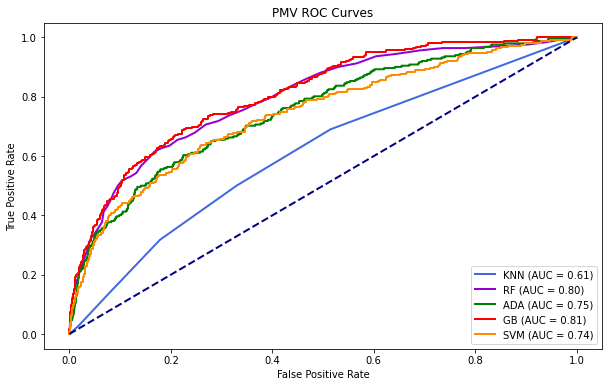

In [26]:
fpr = dict()
tpr = dict()
auroc = dict()

# k-nearest neighbors
knn_probas = knn.predict_proba(x_test)
fpr["KNN"], tpr["KNN"], _ = roc_curve(y_test, knn_probas[:, 1])
auroc["KNN"] = auc(fpr["KNN"], tpr["KNN"])

# random forest
rf_probas = rf.predict_proba(x_test)
fpr["RF"], tpr["RF"], _ = roc_curve(y_test, rf_probas[:, 1])
auroc["RF"] = auc(fpr["RF"], tpr["RF"])

# ada boosting
ada_probas = ada.decision_function(x_test)
fpr["ADA"], tpr["ADA"], _ = roc_curve(y_test, ada_probas)
auroc["ADA"] = auc(fpr["ADA"], tpr["ADA"])

# gradient boosting
gb_probas = gb.decision_function(x_test)
fpr["GB"], tpr["GB"], _ = roc_curve(y_test, gb_probas)
auroc["GB"] = auc(fpr["GB"], tpr["GB"])

# support vector machine
svm_probas = svm.decision_function(x_test)
fpr["SVM"], tpr["SVM"], _ = roc_curve(y_test, svm_probas)
auroc["SVM"] = auc(fpr["SVM"], tpr["SVM"])

'''# bagging classifier
bag_probas = bag.decision_function(x_test)
fpr["BAG"], tpr["BAG"], _ = roc_curve(y_test, bag_probas)
auroc["BAG"] = auc(fpr["BAG"], tpr["BAG"])'''

# plot
plt.figure(figsize=(10,6))
plt.plot(fpr["KNN"], tpr["KNN"], color='royalblue', lw=2, label='KNN (AUC = %0.2f)' % auroc["KNN"])
plt.plot(fpr["RF"], tpr["RF"], color='darkviolet', lw=2, label='RF (AUC = %0.2f)' % auroc["RF"])
plt.plot(fpr["ADA"], tpr["ADA"], color='green', lw=2, label='ADA (AUC = %0.2f)' % auroc["ADA"])
plt.plot(fpr["GB"], tpr["GB"], color='red', lw=2, label='GB (AUC = %0.2f)' % auroc["GB"])
plt.plot(fpr["SVM"], tpr["SVM"], color='darkorange', lw=2, label='SVM (AUC = %0.2f)' % auroc["SVM"])
#plt.plot(fpr["BAG"], tpr["BAG"], color='yellow', lw=2, label='BAG (AUC = %0.2f)' % auroc["BAG"])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PMV ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [27]:
'''bag_probas = bagc.decision_function(x_test)
fpr["SVM"], tpr["SVM"], _ = roc_curve(y_test, bag_probas)
auroc["SVM"] = auc(fpr["SVM"], tpr["SVM"])'''

'bag_probas = bagc.decision_function(x_test)\nfpr["SVM"], tpr["SVM"], _ = roc_curve(y_test, bag_probas)\nauroc["SVM"] = auc(fpr["SVM"], tpr["SVM"])'

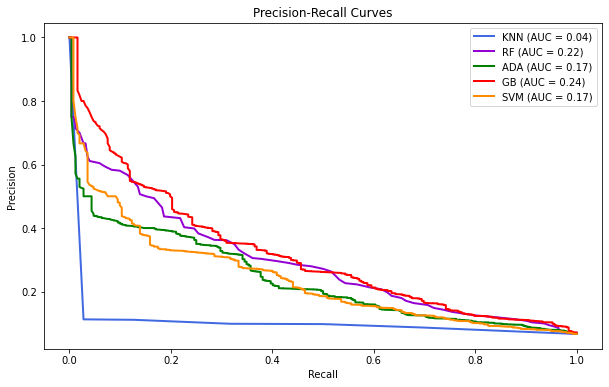

In [28]:
precision = dict()
recall = dict()
auprc = dict()

# k-nearest neighbors
precision["KNN"], recall["KNN"], _ = precision_recall_curve(y_test, knn_probas[:, 1])
precision["KNN"].sort()
auprc["KNN"] = auc(precision["KNN"], recall["KNN"])

# random forest
precision["RF"], recall["RF"], _ = precision_recall_curve(y_test, rf_probas[:, 1])
precision["RF"].sort()
auprc["RF"] = auc(precision["RF"], recall["RF"])

# ada boosting
precision["ADA"], recall["ADA"], _ = precision_recall_curve(y_test, ada_probas)
precision["ADA"].sort()
auprc["ADA"] = auc(precision["ADA"], recall["ADA"])

# gradient boosting
precision["GB"], recall["GB"], _ = precision_recall_curve(y_test, gb_probas)
precision["GB"].sort()
auprc["GB"] = auc(precision["GB"], recall["GB"])

# support vector machine
precision["SVM"], recall["SVM"], _ = precision_recall_curve(y_test, svm_probas)
precision["SVM"].sort()
auprc["SVM"] = auc(precision["SVM"], recall["SVM"])

# plot
plt.figure(figsize=(10,6))
plt.plot(recall["KNN"], precision["KNN"], color='royalblue', lw=2, label='KNN (AUC = %0.2f)' % (auprc["KNN"]))
plt.plot(recall["RF"], precision["RF"], color='darkviolet', lw=2, label='RF (AUC = %0.2f)' % (auprc["RF"]))
plt.plot(recall["ADA"], precision["ADA"], color='green', lw=2, label='ADA (AUC = %0.2f)' % (auprc["ADA"]))
plt.plot(recall["GB"], precision["GB"], color='red', lw=2, label='GB (AUC = %0.2f)' % (auprc["GB"]))
plt.plot(recall["SVM"], precision["SVM"], color='darkorange', lw=2, label='SVM (AUC = %0.2f)' % (auprc["SVM"]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="upper right")
plt.show()

### 2.1: Cox models

#### 2.1.1: CoxPH

In [ ]:
Xt = OneHotEncoder().fit_transform(X)
cph = CoxPHSurvivalAnalysis()
cph.fit(Xt, y)

# get c-index of trained estimator
pred = cph.predict(Xt)
result = concordance_index_censored(y['Censor'], y["Survival"], pred)
print('C-index of Cox model: '+str(result[0]))

In [ ]:
alphas = 10. ** np.linspace(-4,4,10)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(Xt.columns))

In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
plot_coefficients(coefficients, n_highlight=10)

#### 2.1.2: Cox Elastic Net

In [ ]:
coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=100)
)
warnings.simplefilter("ignore", ConvergenceWarning)
coxnet_pipe.fit(Xt, y)

In [ ]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

In [ ]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [ ]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xt.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order[-20:]].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

### 2.2: Random Survival Forest

In [ ]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] =df['duration1']
y

In [ ]:
random_state = 24

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.20, random_state=random_state)

In [ ]:
rsf = RandomSurvivalForest(n_estimators=100,
                            min_samples_split=50,
                            min_samples_leaf=4,
                            max_features="sqrt",
                            n_jobs=-1,
                            random_state=random_state)
rsf.fit(X_train, y_train)
rsf.score(X_test, y_test)

In [ ]:
rsf = RandomSurvivalForest()
parameters = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 200, num = 2)],
              'max_features': ['auto', 'sqrt'],
              'max_depth': [int(x) for x in np.linspace(10, 100, num = 3)],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False]}
rsf_tuned = RandomizedSearchCV(rsf, parameters, n_iter = 10, cv=3, n_jobs=-1, scoring='f1')
rsf_tuned.fit(X_train, y_train)
print ('Best parameters for RSF: {}'.format(rsf_tuned.best_params_))
print ('Cross-validation F1 score: {}'.format(rsf_tuned.best_score_))
print ('Test F1 score: {}'.format(f1_score(y_test, rsf_tuned.predict(X_test))))

In [ ]:
rsf = RandomSurvivalForest(n_estimators=200,
                            min_samples_split=50,
                            min_samples_leaf=3,
                            max_features="sqrt",
                            n_jobs=-1,
                            random_state=random_state)
parameters = {'n_estimators': [100, 200],
              'max_features': ['auto'],
              'max_depth': [50, 100],
              'min_samples_split': [5,10],
              'min_samples_leaf': [2,10],
              'bootstrap': [True, False]}
rsf_tuned = GridSearchCV(rsf, parameters, cv=5, n_jobs=-1, scoring='f1')
rsf_tuned.fit(X_train, y_train)
print ('Best parameters for RF: {}'.format(rf_tuned.best_params_))
print ('Cross-validation F1 score: {}'.format(rf_tuned.best_score_))
print ('Test F1 score: {}'.format(f1_score(y_test, rf_tuned.predict(x_test))))

In [ ]:
perm = PermutationImportance(rsf, n_iter=3, random_state=random_state)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)

### 2.3: GBM Survival

In [ ]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] =df['duration1']
y

# get X_train, X_test, y_train, y_test
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.25, random_state=random_state)

In [ ]:
est_cph_tree = GradientBoostingSurvivalAnalysis(
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0
)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

In [ ]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(
    learning_rate=1.0, max_depth=1, random_state=0
)
for i in range(10, 31,5):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

In [ ]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [ ]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    learning_rate=1.0, random_state=0
)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)

In [ ]:
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [ ]:
coef = pd.Series(est_cph_ls.coef_, ["Intercept"] + Xt.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

## 3: Exploring language and ventilation duration 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

dfImputed_onehot = dfImputed.copy()
dfImputed1 = pd.get_dummies(dfImputed_onehot, columns = ['ethnicity', 'language'], prefix = ['eth', 'lang'])
onehot_cols = [i for i in list(dfImputed1.columns) if i not in ['ethnicity', 'marital_status', 'language', 'admission_location']]
dfImputed1['duration1'] = df['duration1']
dfImputed1 = dfImputed1.dropna(axis=0, how='any')

In [ ]:
dfImputed1

In [ ]:
from matplotlib import pyplot
from scipy.stats import kstest, norm, pearsonr, ttest_ind

x = dfImputed1['lang_ENGL']
y = df['duration1'].dropna(axis=0,how='any')

#testing for normalcy
mu, std = norm.fit(x)
n = norm(loc=mu, scale=std)
normalcy_p = kstest(x, n.cdf)[1]
print('p-val: '+ str(normalcy_p))

pyplot.scatter(x,y)
covariance = np.cov(x,y)
print('Covariance matrix: ')
print(covariance)

#find pearson R
corr, _ = pearsonr(x,y)
print('Pearsons R: %.3f' %corr)

In [ ]:
import statsmodels.api as sm

univariable = pd.DataFrame(index = ['eth_white','lang_ENGL'], columns = ['OR (95% CI)','p-value'])

p_value = []
OR = []
time = []
for column in ['lang_ENGL']:
    for int_timelimit in range(0,48,1):
        X = dfImputed1[column].values
        X = sm.add_constant(X)
        y = pd.cut(df['duration1'].dropna(how='any'),bins=[-0.1,int_timelimit,4000],labels=[0,1])
        logit = sm.Logit(y, X)
        model = logit.fit(method='bfgs',disp = False)
        model_odds = pd.DataFrame(np.exp(model.params), columns=['OR'])
        model_odds['p-value'] = model.pvalues
        model_odds[['2.5%','97.5%']]= np.exp(model.conf_int())
        model_odds.rename(index={'x1': column}, inplace = True)
        # insert it into the dataframe 'univariable'
        univariable.at[column,'OR (95% CI)'] = '{OR:.3f} ({lower:.3f} to {upper:.3f})'.format(OR = model_odds.at[column, 'OR'], 
                                                                                            lower = model_odds.at[column, '2.5%'], 
                                                                                            upper = model_odds.at[column, '97.5%'])
        univariable.at[column,'p-value'] = '{0:.3f}'.format(model_odds.at[column, 'p-value'])
        p_value.append(model_odds.at[column, 'p-value'])
        OR.append(model_odds.at[column, 'OR'])
        time.append(int_timelimit)

univariable

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(time, OR, label='OR',color='blue')
ax.set_xlabel("ventilation time")
ax.set_ylabel("OR")

ax2=ax.twinx()
ax2.plot(time, p_value, label='p-val',color='orange')
ax2.set_ylabel("p-val")


In [ ]:
x1 = dfImputed1['duration1'][dfImputed1['lang_ENGL']==1].dropna(axis=0,how='any')
x2 = dfImputed1['duration1'][dfImputed1['lang_ENGL']==0].dropna(axis=0,how='any')
plt.hist(x1,bins=[-0.1,2,4,6,10,13,16,20,25,30,40,50,60],range=(0,60))
plt.hist(x2,bins=[-0.1,2,4,6,10,13,16,20,25,30,40,50,60],range=(0,60),color='orange')
print('mean English: '+str(np.mean(x1)))
print('mean non-English: '+str(np.mean(x2)))
print('t_test p-val;: '+str(ttest_ind(x1, x2)[1]))